In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import pathlib

In [3]:
from collections import OrderedDict as OD

In [4]:
import numpy as np 
import pandas as pd 
import xarray as xr

**NOTE**: an alternative to the code suggested here to fix the issue with the time variable is to to run first
    
    
```
cdo settunits,days cmorph_monthly.nc cmorph_monthly_jan1998-jan2020.nc

```

in the `CDO` environment  

in order to set the calendar so that it can be read by xarray 

### set the year here 

In [5]:
year = 2019

In [6]:
dset = xr.open_dataset('../data/CMORPH/cmorph_monthly_from_KNMI.nc', decode_times=False)

In [7]:
dset

<xarray.Dataset>
Dimensions:  (lat: 240, lon: 720, time: 269)
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 4.0 ... 265.0 266.0 267.0 268.0
  * lon      (lon) float32 0.25 0.75 1.25 1.75 ... 358.25 358.75 359.25 359.75
  * lat      (lat) float32 -59.75 -59.25 -58.75 -58.25 ... 58.75 59.25 59.75
Data variables:
    prcp     (time, lat, lon) float32 ...
Attributes:
    CDI:                        Climate Data Interface version 1.9.8 (https:/...
    history:                    Thu Jun 04 10:54:23 2020: cdo -L settaxis,199...
    institution:                NCEP/CPC
    Conventions:                CF-1.0
    title:                      CMORPH Version 1.0, RAW daily precip from 00Z...
    source_url:                 http://www.cpc.ncep.noaa.gov/products/janowia...
    reference:                  Joyce, R. J., J. E. Janowiak, P. A. Arkin, an...
    geospatial_lat_min:         -60.0
    geospatial_lat_max:         60.0
    geospatial_lat_units:       degrees_north
    geospatial_lon_min:         0.0
    geospatial_lon_max:         360.0
    geospatial_lon_units:       degrees_east
    geospatial_lat_resolution:  0.5
    geospatial_lon_resolution:  0.5
    time_coverage_start:        1998-01-01
    time_coverage_end:          2020-05-31
    climexp_url:                https://climexp.knmi.nl/select.cgi?cmorph_daily
    frequency:                  mon
    CDO:                        Climate Data Operators version 1.9.8 (https:/...

In [8]:
dset['time'] = pd.date_range(start='1998-1-1', periods=len(dset.time), freq='MS')

### restrict the domain to [110.,-30.,280.,20.] for tthe sector plots

In [9]:
dset = dset.sel(lat=slice(-30., 20.), lon=slice(150, 360 - 90))

### calculate the climatology 

In [10]:
clim = dset.sel(time=slice('1998','2018'))

In [11]:
clim = clim.groupby(clim.time.dt.month).mean('time')

In [12]:
lon_sectors = [150, 180, (360-150), (360-120), (360-90)]
lon_labels = ['150E','180','150W','120W','90W']

In [13]:
season_dict = OD()

season_dict[f"(a) January - March {year}"] = [1,3]

season_dict[f"(b) April - June {year}"] = [4,6]

season_dict[f"(b) July - September {year}"] = [7,9]

season_dict[f"(b) October - December {year}"] = [10, 12]

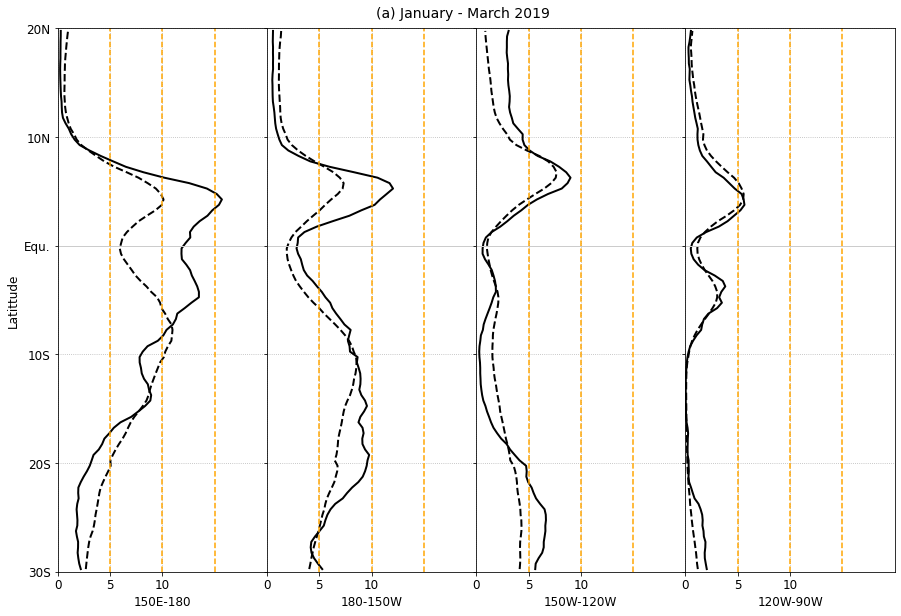

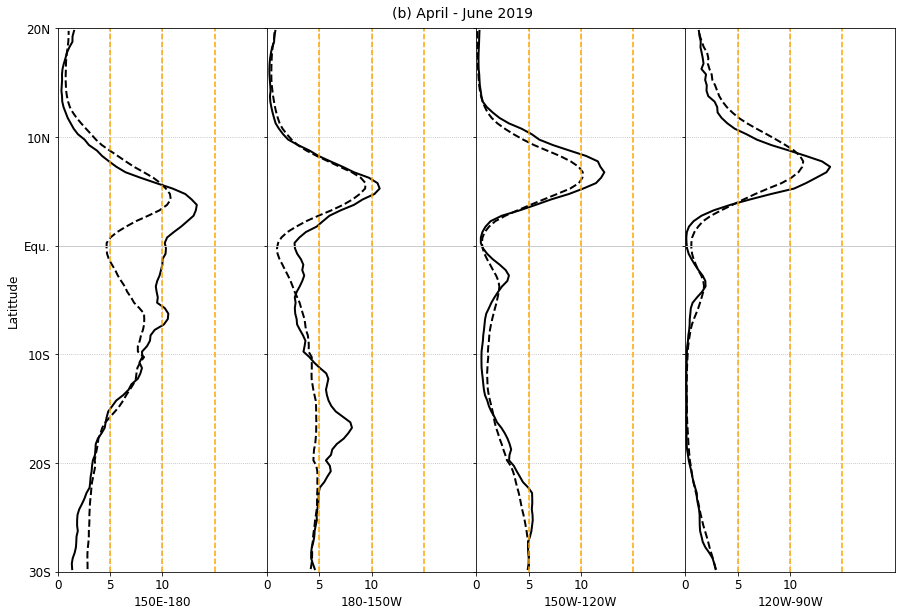

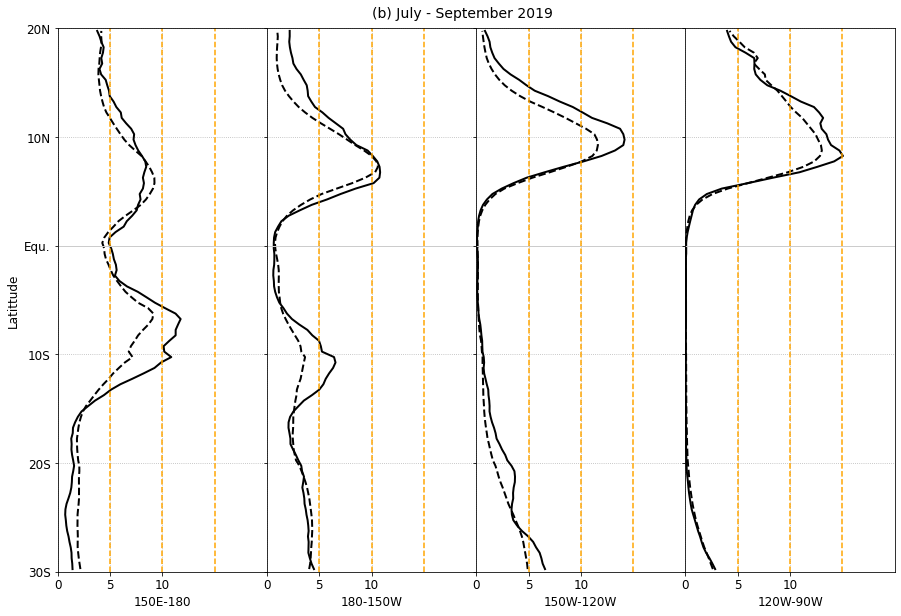

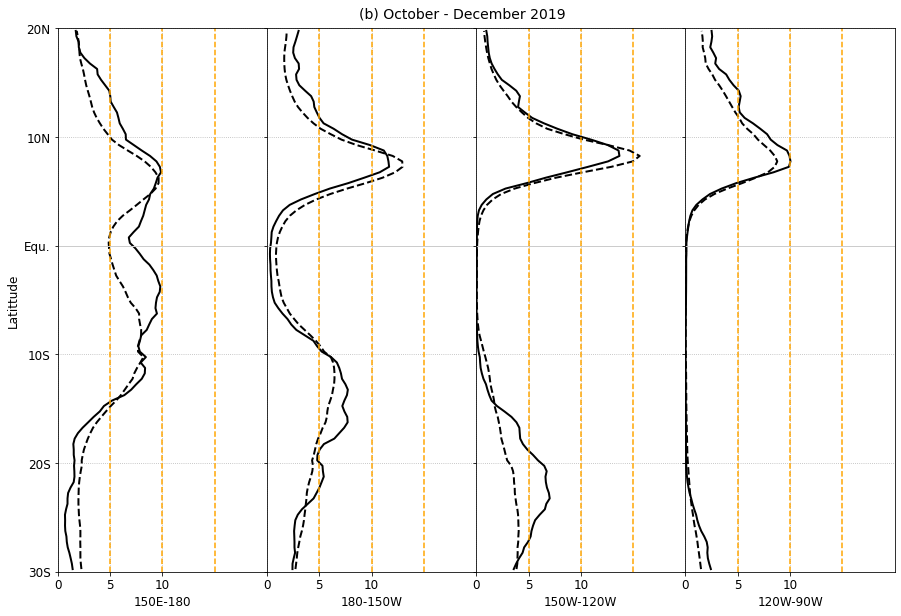

In [14]:
for seas in season_dict.keys():
    
    title = seas 
    
    seas_months = season_dict[seas]
    
    seas_range = [f"{year}-{str(seas_months[0]).zfill(2)}", f"{year}-{str(seas_months[1]).zfill(2)}"]
    
    dset_seas = dset.sel(time=slice(seas_range[0], seas_range[1])).mean('time')
    
    clim_seas = clim.sel(month=slice(seas_months[0], seas_months[1])).mean('month')
    
    f, axes = plt.subplots(ncols=4, figsize=(15,10), sharey=True)

    f.subplots_adjust(wspace=0)

    axes = axes.flatten()

    for i in range(4): 

        ax = axes[i]

        sector_seas = dset_seas.sel(lon=slice(lon_sectors[i],lon_sectors[i+1])).mean('lon')

        sector_clim = clim_seas.sel(lon=slice(lon_sectors[i],lon_sectors[i+1])).mean('lon') 

        ax.plot(sector_clim['prcp'].data, sector_clim['lat'].data, color='k', lw=2, ls='--') 

        ax.plot(sector_seas['prcp'].data, sector_seas['lat'].data, color='k', lw=2) 

        ax.set_ylim(-30, 20)

        ax.grid(ls=':')

        ax.axhline(0, ls='-', color='0.8', lw=1)

        for x in [5, 10, 15]: 
            ax.axvline(x, color='orange',ls='--')


        ax.set_xlim(0, 20)
        ax.set_yticklabels(['30S','20S','10S','Equ.','10N','20N'], fontsize=12); 
        ax.set_xlabel(f"{lon_labels[i]}-{lon_labels[i+1]}", fontsize=12)

        if i == 0: 
            ax.set_ylabel('Latittude', fontsize=12)
        ax.set_xticks([0,5,10])
        ax.set_xticklabels([0,5,10,15], fontsize=12);

    f.suptitle(title, fontsize=14, y=0.91)
    
f.savefig(f"../figures/sector_plot_{seas[4:].replace('-','_').replace(' ','_')}.png", dpi=200)